In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import math
import requests
from bs4 import BeautifulSoup
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
pd.set_option("display.max_columns",100)

from helper_functions.functions import Helpers
from joblib import dump
from joblib import load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

grounds = np.load('grounds.npy')
grounds = np.append(grounds, 'other')
enc.fit(pd.DataFrame(grounds))
# dump(enc, 'models/enc.joblib') 

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [4]:
enc = load('models/enc.joblib')

In [5]:
## Proxy settings when using cntlm
http_proxy  = "http://localhost:3128"
https_proxy = "https://localhost:3128"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
            }
proxyDict = None

In [6]:
mapping = {
    'Richmond': 'richmond',
    'West Coast': 'westcoast',
    'Sydney': 'swans',
    'Adelaide': 'adelaide',
    'Geelong': 'geelong',
    'Greater Western Sydney': 'gws',
    'Melbourne': 'melbourne',
    'Port Adelaide': 'padelaide',
    'Collingwood': 'collingwood',
    'Hawthorn': 'hawthorn',
    'Essendon': 'essendon',
    'Western Bulldogs': 'bullldogs',
    'St Kilda': 'stkilda',
    'North Melbourne': 'kangaroos',
    'Kangaroos' : 'kangaroos',
    'Fremantle': 'fremantle',
    'Brisbane Lions': 'brisbanel',
    'Gold Coast': 'goldcoast',
    'Carlton': 'carlton'
}
teams = list(mapping.keys())

In [120]:
from data_prep.team_history import History
team_df = History(mapping, proxyDict, enc).generate_team_history(season_list=range(17))
# team_df = History(mapping, proxyDict, enc).generate_team_history(season_list=[0]) # current season

Richmond 0
Richmond 1
Richmond 2
Richmond 3
Richmond 4
Richmond 5
Richmond 6
Richmond 7
Richmond 8
Richmond 9
Richmond 10
Richmond 11
Richmond 12
Richmond 13
Richmond 14
Richmond 15
Richmond 16
West Coast 0
West Coast 1
West Coast 2
West Coast 3
West Coast 4
West Coast 5
West Coast 6
West Coast 7
West Coast 8
West Coast 9
West Coast 10
West Coast 11
West Coast 12
West Coast 13
West Coast 14
West Coast 15
West Coast 16
Sydney 0
Sydney 1
Sydney 2
Sydney 3
Sydney 4
Sydney 5
Sydney 6
Sydney 7
Sydney 8
Sydney 9
Sydney 10
Sydney 11
Sydney 12
Sydney 13
Sydney 14
Sydney 15
Sydney 16
Adelaide 0
Adelaide 1
Adelaide 2
Adelaide 3
Adelaide 4
Adelaide 5
Adelaide 6
Adelaide 7
Adelaide 8
Adelaide 9
Adelaide 10
Adelaide 11
Adelaide 12
Adelaide 13
Adelaide 14
Adelaide 15
Adelaide 16
Geelong 0
Geelong 1
Geelong 2
Geelong 3
Geelong 4
Geelong 5
Geelong 6
Geelong 7
Geelong 8
Geelong 9
Geelong 10
Geelong 11
Geelong 12
Geelong 13
Geelong 14
Geelong 15
Geelong 16
Greater Western Sydney 0
Greater Western Sydney

In [122]:
from data_prep.team_history import History
# History(mapping, proxyDict, enc).generate_game_data('training-all/', team_df,season_list=range(16))
# History(mapping, proxyDict, enc).generate_game_data('training-all/', team_df, season_list=[0]) # current season

# Using the "look back to previous season"
History(mapping, proxyDict, enc).generate_game_data('training-hist/', team_df,season_list=range(17))
# History(mapping, proxyDict, enc).generate_game_data('training-hist/', team_df, season_list=[0]) # current season

2019 Richmond
2019 West Coast
2019 Sydney
2019 Adelaide
2019 Geelong
2019 Greater Western Sydney
2019 Melbourne
2019 Port Adelaide
2019 Collingwood
2019 Hawthorn
2019 Essendon
2019 Western Bulldogs
2019 St Kilda
2019 North Melbourne
2019 Fremantle
2019 Brisbane Lions
2019 Gold Coast
2019 Carlton
2018 Richmond
2018 West Coast
2018 Sydney
2018 Adelaide
2018 Geelong
2018 Greater Western Sydney
2018 Melbourne
2018 Port Adelaide
2018 Collingwood
2018 Hawthorn
2018 Essendon
2018 Western Bulldogs
2018 St Kilda
2018 North Melbourne
2018 Fremantle
2018 Brisbane Lions
2018 Gold Coast
2018 Carlton
2017 Richmond
2017 West Coast
2017 Sydney
2017 Adelaide
2017 Geelong
2017 Greater Western Sydney
2017 Melbourne
2017 Port Adelaide
2017 Collingwood
2017 Hawthorn
2017 Essendon
2017 Western Bulldogs
2017 St Kilda
2017 North Melbourne
2017 Fremantle
2017 Brisbane Lions
2017 Gold Coast
2017 Carlton
2016 Richmond
2016 West Coast
2016 Sydney
2016 Adelaide
2016 Geelong
2016 Greater Western Sydney
2016 Melbour

In [123]:
X_list = []
y_list = []
rnd = 1 #Filter out rounds before this number

## Easy seasons 11, 12, 13, 16 [8,7,6,3]. Remove to build conservative models
cons = [8,7,6,3]
if cons:
    seasons = [i for i in range(12) if i not in cons]
else:
    seasons = range(13)

for i in seasons:
    X = np.load('training-hist/training-'+str(2019-i)+'.npy')

    mask = np.isnan(X).any(axis=1)
    if mask.sum() > 0:
        index = np.where(mask==True)[0][0] ## X8 has a row containing nulls
        X = np.delete(X, index, 0)
    mask2 = np.array([(row[0] >= rnd) for row in X])
    X_list.append(X[mask2])

    y = np.load('training-hist/results-'+str(2019-i)+'.npy')
    if mask.sum() > 0:
        y = np.delete(y, index, 0)
    y_list.append(y[mask2])
    
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(X.shape)
print(y.shape)

print('Wins vs losses',np.sum(y)/float(len(y)))

(1508, 18)
(1508,)
Wins vs losses 0.5689655172413793


In [124]:
from data_prep.feature_eng import Features
cols = Features().cols()
df = Features().div_cols(X)
df.head()

,Rnd,h_F_mean,h_A_mean,h_M_mean,h_R_mean,h_perc,a_F_mean,a_A_mean,a_M_mean,a_R_mean,a_perc,grnd,perc,R_mean,F_ph_na,F_ph_pa,F_nh_na,F_nh_pa,A_nh_pa,A_nh_na,A_ph_pa,A_ph_na
0,2.0,98.500000,73.666667,24.833333,1.000000,1.337104,84.666667,75.666667,9.000000,0.500000,1.118943,23.0,1.194971,2.000000,1.699464,1.096372,1.267262,0.817547,0.671084,0.963493,0.980586,1.407852
1,5.0,92.444444,85.444444,7.000000,0.777778,1.081925,75.333333,82.777778,-7.444444,0.444444,0.910067,32.0,1.188840,1.750000,1.662145,1.281116,1.157107,0.891853,0.659892,0.929049,1.105492,1.556400
2,6.0,92.100000,83.600000,8.500000,0.800000,1.101675,89.500000,87.500000,2.000000,0.500000,1.022857,23.0,1.077056,1.600000,1.761942,0.915549,1.247480,0.648222,0.555915,0.994590,0.933540,1.670199
3,9.0,89.923077,81.769231,8.153846,0.769231,1.099718,85.461538,76.153846,9.307692,0.692308,1.122222,23.0,0.979947,1.111111,1.490420,1.103767,0.982581,0.727674,0.611485,1.083894,1.068007,1.893108
4,10.0,90.285714,80.142857,10.142857,0.785714,1.126560,88.285714,81.000000,7.285714,0.500000,1.089947,12.0,1.033591,1.571429,1.797874,0.928701,1.204537,0.622210,0.584586,0.921189,1.032716,1.627350


In [125]:
df.describe()

,Rnd,h_F_mean,h_A_mean,h_M_mean,h_R_mean,h_perc,a_F_mean,a_A_mean,a_M_mean,a_R_mean,a_perc,grnd,perc,R_mean,F_ph_na,F_ph_pa,F_nh_na,F_nh_pa,A_nh_pa,A_nh_na,A_ph_pa,A_ph_na
count,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000
mean,11.767241,89.473351,89.691101,-0.217750,0.501993,1.025416,89.706808,89.503041,0.203766,0.507211,1.031231,20.657825,1.051482,1.230030,1.755255,1.015192,1.027376,0.593974,0.598059,1.032579,1.019098,1.760387
std,6.598109,12.641476,12.725085,21.010648,0.200748,0.242146,12.679783,12.943236,21.241064,0.203627,0.245862,11.607363,0.357478,0.948757,0.396325,0.185563,0.264802,0.129579,0.128606,0.256840,0.184277,0.388527
min,1.000000,56.666667,56.600000,-68.000000,0.000000,0.497041,51.200000,58.571429,-69.200000,0.000000,0.451499,0.000000,0.269544,0.000000,0.798529,0.506338,0.347210,0.271082,0.249692,0.431604,0.593987,0.805024
25%,6.000000,81.393750,80.734450,-15.025000,0.363636,0.847218,82.000000,80.230000,-14.656250,0.360000,0.854167,12.000000,0.791634,0.666667,1.483542,0.888515,0.836322,0.504551,0.509372,0.857418,0.895089,1.496780
50%,12.000000,88.733202,88.857143,1.097222,0.500000,1.012660,89.133333,88.632500,1.638889,0.500000,1.018390,23.000000,0.986315,1.000000,1.703472,0.996636,0.996080,0.582098,0.586612,1.001836,1.008924,1.710579
75%,18.000000,97.559091,98.085227,13.500000,0.642857,1.165432,97.602778,98.000000,13.750000,0.666667,1.171399,29.000000,1.256823,1.500000,1.965978,1.123428,1.170966,0.668690,0.674582,1.176882,1.126817,1.983116
max,23.000000,135.666667,138.500000,69.800000,1.000000,2.233216,140.600000,147.000000,70.000000,1.000000,1.991501,47.000000,2.561325,8.000000,3.821908,1.862560,2.379574,1.084103,1.097084,2.132427,1.870063,3.599287


In [ ]:
from modelling.training import Training
from scipy.stats import uniform
from scipy.stats import randint

spaceR = {
        'n_estimators': randint(low=200, high=850),
        'max_depth': randint(low=3, high=6),
        'learning_rate': uniform(0.001, 0.05),
        'gamma': uniform(0.04, 0.09),
        'min_child_weight': randint(low=3, high=4),
        'scale_pos_weight': uniform(0.9, 0.2),
        'max_delta_step': randint(low=3, high=5),
        'colsample_bytree': uniform(0.1, 0.9),
        'colsample_bylevel': uniform(0.1, 0.9),
        'colsample_bynode': uniform(0.1, 0.9),
        'subsample': uniform(0.1, 0.9),
        'reg_lambda': uniform(1.0, 1.0),
        'reg_alpha': uniform(1.0, 1.0),
        }
scores, val_scores, best_models = Training(n_calls=350).trainR(X_list, y_list, space=spaceR)

In [133]:
from modelling.training import Training
from skopt.space import Real, Integer

spaceB = {
    'n_estimators': Integer(200, 850),
    'max_depth': Integer(3, 6),
    'learning_rate': Real(0.001, 0.05, "uniform"),
    'gamma': Real(0.04, 0.09, "uniform"),
    'min_child_weight': Integer(3, 5),
    'scale_pos_weight': Real(0.9, 1.1, "uniform"),
    'max_delta_step': Integer(3, 5),
    'colsample_bytree': Real(0.1, 1.0, "uniform"),
    'colsample_bylevel': Real(0.1, 1.0, "uniform"),
    'colsample_bynode': Real(0.1, 1.0, "uniform"),
    'subsample': Real(0.1, 0.5, "uniform"),
    'reg_lambda': Real(1.0, 2, "uniform"),
    'reg_alpha': Real(1.0, 2, "uniform"),
        }
scores, val_scores, best_models = Training(n_calls=50).trainB(X_list, y_list, n_points=1, space=spaceB, cv=5)

Season 2019
Bayes CV search took 137.96 seconds for 50 candidates parameter settings.
val. score: 34.116704561017634
test score: 10.779591998893096

Season 2018
Bayes CV search took 100.44 seconds for 50 candidates parameter settings.
val. score: 28.93514385794757
test score: 32.95229214934542

Season 2017
Bayes CV search took 118.11 seconds for 50 candidates parameter settings.
val. score: 31.948108927910987
test score: 15.335307386299341

Season 2016
Bayes CV search took 142.49 seconds for 50 candidates parameter settings.
val. score: 29.08011380388533
test score: 29.225265574998616

Season 2015
Bayes CV search took 129.56 seconds for 50 candidates parameter settings.
val. score: 31.34096397937478
test score: 21.40702141591686

Season 2014
Bayes CV search took 128.08 seconds for 50 candidates parameter settings.
val. score: 30.790178896944923
test score: 18.495467605451882

Season 2013
Bayes CV search took 122.69 seconds for 50 candidates parameter settings.
val. score: 29.5287866795

In [ ]:
from modelling.training_RF import Training
scores, val_scores, best_models = Training(n_calls=50).trainB(X_list, y_list, n_points=1, cv=5)

In [134]:
scores = scores[1:]
val_scores = val_scores[1:]
scores

[32.95229214934542,
 15.335307386299341,
 29.225265574998616,
 21.40702141591686,
 18.495467605451882,
 24.842857181651837,
 18.230840192825937]

conservative

Mean test scores 22.927007358069982
Mean validation scores 30.4506612914585


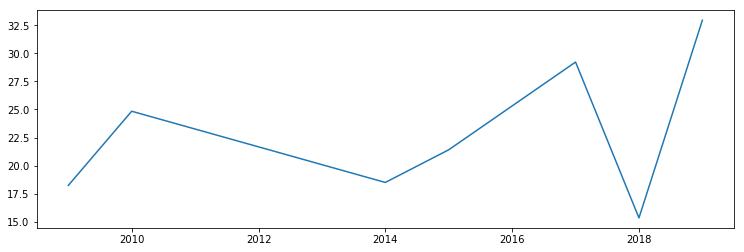

In [135]:
plt.figure(figsize=(12.5,4))
if cons:
    print('conservative')
    x_labels = [2019-i for i in range(11) if i not in cons]
    plt.plot(x_labels, scores)
else:
    plt.plot([2019-i for i in range(11)], scores)
print("")
print("Mean test scores", np.mean(scores))
print("Mean validation scores", np.mean(val_scores))

In [136]:
rows = []
for model in best_models:
    rows.append(model.get_params())
pd.DataFrame(rows).describe()

,base_score,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,n_estimators,n_jobs,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample
count,8.0,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.0,8.0,8.000000,8.000000,8.000000,8.000000
mean,0.5,0.515411,0.313386,0.620774,0.070168,0.014227,3.875000,3.625000,4.12500,452.875000,-1.0,0.0,1.523284,1.462240,0.990086,0.295936
std,0.0,0.242572,0.240527,0.271684,0.016594,0.011021,0.834523,0.744024,0.64087,197.095653,0.0,0.0,0.333435,0.307028,0.040833,0.193849
min,0.5,0.118032,0.100000,0.178077,0.040000,0.006740,3.000000,3.000000,3.00000,200.000000,-1.0,0.0,1.142535,1.105752,0.923948,0.100000
25%,0.5,0.425429,0.142510,0.451257,0.062198,0.007889,3.000000,3.000000,4.00000,330.250000,-1.0,0.0,1.238991,1.232295,0.971324,0.100000
50%,0.5,0.520789,0.280685,0.668174,0.068531,0.008828,4.000000,3.500000,4.00000,453.000000,-1.0,0.0,1.465692,1.440958,0.988068,0.290379
75%,0.5,0.617315,0.352712,0.822997,0.084781,0.015131,4.250000,4.000000,4.25000,562.000000,-1.0,0.0,1.803460,1.659525,1.007477,0.490046
max,0.5,0.905953,0.836267,0.923887,0.090000,0.034209,5.000000,5.000000,5.00000,728.000000,-1.0,0.0,1.963169,1.998526,1.066278,0.500000


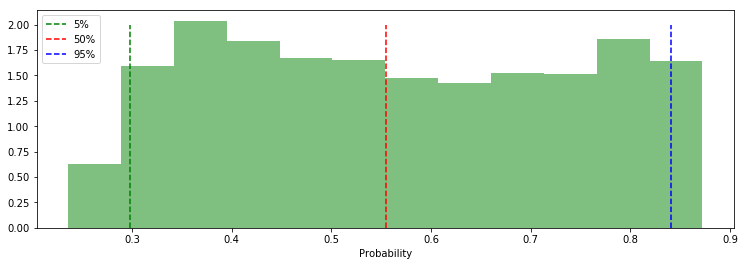

In [137]:
plt.figure(figsize=(12.5,4))
line_height = 2
data = Helpers().averagingModels(X, best_models)
_ = plt.hist(data, bins='auto', density=True, facecolor='green', alpha=0.5)

plt.vlines(np.percentile(data, 5), 0, line_height, linestyle="--", colors='green', label="5%")
plt.vlines(np.percentile(data, 50), 0, line_height, linestyle="--", colors='red', label="50%")
plt.vlines(np.percentile(data, 95), 0, line_height, linestyle="--", colors='blue', label="95%")
plt.xlabel('Probability')
plt.legend()

In [138]:
from helper_functions.functions import Helpers

features = Features().div_cols(X_list[0]).columns

imp = pd.DataFrame(data=Helpers().averagingImp(best_models),
             index=features,
             columns=['importance']).sort_values(by=['importance'], ascending=False)
print(imp.shape)
imp

(22, 1)


,importance
perc,0.060889
A_nh_pa,0.056700
A_ph_pa,0.054713
A_nh_na,0.053719
F_nh_pa,0.052675
F_ph_pa,0.051865
h_perc,0.049505
F_ph_na,0.049234
F_nh_na,0.048353
h_R_mean,0.047906


## Model Analysis

In [145]:
if cons:
    data_A = np.load('model_A_scores_cons.npy')
else:    
    data_A = np.load('model_A_scores.npy')
data_B = scores.copy()
print(np.sort(data_A))
print(np.sort(data_B))
print(np.mean(data_A))
print(np.mean(data_B))

[14.4482056  19.92936124 20.43671003 20.73366636 21.94476933 24.18834818
 25.50968238]
[15.33530739 18.23084019 18.49546761 21.40702142 24.84285718 29.22526557
 32.95229215]
21.02724901563138
22.927007358069982


In [146]:
import pymc3 as pm
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    alpha_A = pm.Exponential('alpha_A', 1/10)
    beta_A = pm.Uniform('beta_A', lower=0, upper=1)
    alpha_B = pm.Exponential('alpha_B', 1/10)
    beta_B = pm.Uniform('beta_B', lower=0, upper=1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", alpha_A/beta_A - alpha_B/beta_B)
    
    obs_A = pm.Gamma("obs_A", alpha=alpha_A, beta=beta_A, observed=data_A)
    obs_B = pm.Gamma("obs_B", alpha=alpha_B, beta=beta_B, observed=data_B)
    
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_B]
>Metropolis: [alpha_B]
>Metropolis: [beta_A]
>Metropolis: [alpha_A]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:14<00:00, 5269.84draws/s]
The number of effective samples is smaller than 10% for some parameters.


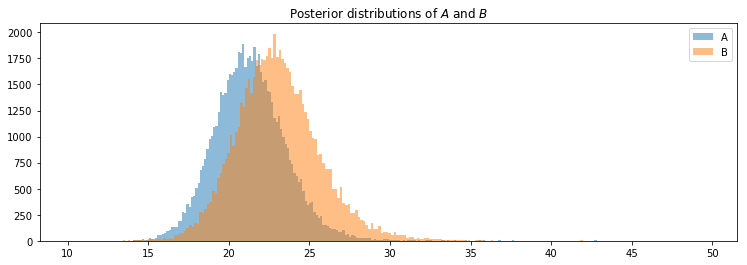

In [147]:
plt.figure(figsize=(12.5,4))
plt.title("Posterior distributions of $A$ and $B$")
plt.hist(burned_trace["alpha_A"]/burned_trace["beta_A"], bins='auto', histtype="stepfilled", alpha=0.5, label="A")
plt.hist(burned_trace["alpha_B"]/burned_trace["beta_B"], bins='auto', histtype="stepfilled", alpha=0.5, label="B")
plt.legend()

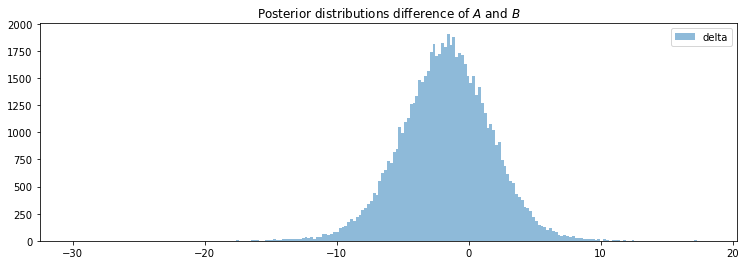

In [148]:
plt.figure(figsize=(12.5,4))
plt.title("Posterior distributions difference of $A$ and $B$")
plt.hist(burned_trace["delta"], bins='auto', histtype="stepfilled", alpha=0.5, label="delta")
plt.legend()

In [149]:
print("Probability model A is WORSE than model B: %.3f" % \
    np.mean(burned_trace["delta"] < 0))

print("Probability model A is BETTER than model B: %.3f" % \
    np.mean(burned_trace["delta"] > 0))

Probability model A is WORSE than model B: 0.700
Probability model A is BETTER than model B: 0.300


In [153]:
# if cons:
#     np.save('model_A_scores_cons.npy', data_B)
# else:
#     np.save('model_A_scores.npy', data_B)

## Save models

In [152]:
from joblib import dump
if cons:
    for i in range(len(best_models)):
        dump(best_models[i], 'models/model_cons'+str(i)+'.joblib') 
else:
    for i in range(len(best_models)):
        dump(best_models[i], 'models/model'+str(i)+'.joblib') 

## Load models

In [127]:
from joblib import load
# model = load('models2/model.joblib')
best_models = []
# for i in range(12):
#     best_models.append(load('models/model'+str(i)+'.joblib'))
for i in range(8):
    best_models.append(load('models/model_cons'+str(i)+'.joblib'))

## Scoring

In [128]:
from data_prep.web_scraping import Scrape

games = []
start = 275
for i in range(start,start+9):
    games.append(Scrape(mapping, proxyDict).scrape_game(i))
games

[['Richmond', 'Brisbane Lions'],
 ['West Coast', 'Hawthorn'],
 ['North Melbourne', 'Melbourne'],
 ['Gold Coast', 'Greater Western Sydney'],
 ['Port Adelaide', 'Fremantle'],
 ['Geelong', 'Carlton'],
 ['Collingwood', 'Essendon'],
 ['Western Bulldogs', 'Adelaide'],
 ['Sydney', 'St Kilda']]

In [129]:
from modelling.scoring import Scoring
scoring_df = Scoring(mapping, proxyDict, enc).score_data(games)
scoring = scoring_df.values

In [130]:
scoring_df

,Rnd,h_F_mean,h_A_mean,h_M_mean,h_R_mean,h_perc,a_F_mean,a_A_mean,a_M_mean,a_R_mean,a_perc,grnd,perc,R_mean,F_ph_na,F_ph_pa,F_nh_na,F_nh_pa,A_nh_pa,A_nh_na,A_ph_pa,A_ph_na
0,23.0,87.96,76.40,11.56,0.76,1.151309,91.04,79.80,11.24,0.68,1.140852,17.0,1.009166,1.117647,1.538793,1.002953,0.909732,0.592944,0.556137,0.895377,0.995913,1.603415
1,23.0,89.12,76.32,12.80,0.72,1.167715,79.12,73.92,5.20,0.56,1.070346,12.0,1.090969,1.285714,1.723786,1.209778,1.007573,0.707130,0.609563,1.091408,0.999549,1.789667
2,23.0,84.88,85.08,-0.20,0.44,0.997649,76.68,87.56,-10.88,0.32,0.875742,23.0,1.139204,1.375000,2.102128,1.092568,1.134586,0.589694,0.588668,0.909644,1.011821,1.563525
3,23.0,60.32,103.72,-43.40,0.12,0.581566,86.92,77.36,9.56,0.56,1.123578,47.0,0.517602,0.214286,1.339451,0.620386,0.852846,0.395008,0.763415,1.323054,1.350952,2.341298
4,23.0,80.00,81.24,-1.24,0.40,0.984737,71.56,82.24,-10.68,0.40,0.870136,29.0,1.131704,1.000000,2.232342,1.066484,1.225655,0.585547,0.518150,1.012327,0.975307,1.905489
5,23.0,91.88,64.88,27.00,0.68,1.416153,71.04,90.36,-19.32,0.28,0.786189,23.0,1.801289,2.428571,2.281266,1.321787,1.244286,0.720951,0.374215,0.721082,0.716426,1.380496
6,23.0,87.00,72.52,14.48,0.68,1.199669,81.84,82.56,-0.72,0.56,0.991279,29.0,1.210223,1.214286,1.917557,1.015948,1.151952,0.610320,0.535748,0.960584,0.832550,1.492743
7,23.0,87.04,80.92,6.12,0.56,1.075630,85.12,79.08,6.04,0.52,1.076378,0.0,0.999305,1.076923,1.871251,0.943741,1.178832,0.594528,0.558487,0.917913,1.087369,1.787168
8,23.0,76.44,78.96,-2.52,0.40,0.968085,75.92,90.96,-15.04,0.36,0.834653,23.0,1.159866,1.111111,1.439807,1.010313,1.001913,0.703043,0.541325,0.876337,0.862970,1.397041


In [150]:
def modelStats(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(X)[:,1] for model in models
    ])
    return [np.mean(predictions, axis=1), np.median(predictions, axis=1), np.std(predictions, axis=1), 
            np.max(predictions, axis=1), np.min(predictions, axis=1)]

arr = np.c_[ games, best_models[0].predict_proba(scoring)[:,1], modelStats(scoring,best_models)[0],
           modelStats(scoring,best_models)[1],modelStats(scoring,best_models)[2],
            modelStats(scoring,best_models)[3], modelStats(scoring,best_models)[4]] 
df = pd.DataFrame(arr,columns=['home','away', 'prob','prob_avg', 'prob_med', 'prob_std', 'prob_max', 'prob_min'])
df['Home_Win_Score'] = 1 + np.log2(df['prob_avg'].astype(float))
df['Away_Win_Score'] = 1 + np.log2(1-df['prob_avg'].astype(float))

df['correct'] = df[['Home_Win_Score', 'Away_Win_Score']].max(axis=1)
df['incorrect'] = df[['Home_Win_Score', 'Away_Win_Score']].min(axis=1)
df

,home,away,prob,prob_avg,prob_med,prob_std,prob_max,prob_min,Home_Win_Score,Away_Win_Score,correct,incorrect
0,Richmond,Brisbane Lions,0.6133586,0.60716975,0.6130944,0.0240925,0.64017856,0.5740462,0.280172,-0.348022,0.280172,-0.348022
1,West Coast,Hawthorn,0.65661055,0.64019054,0.6410437,0.011408197,0.65661055,0.6145386,0.356573,-0.474695,0.356573,-0.474695
2,North Melbourne,Melbourne,0.7040163,0.7012587,0.70507324,0.024537658,0.74768925,0.6606272,0.488019,-0.743031,0.488019,-0.743031
3,Gold Coast,Greater Western Sydney,0.23927037,0.27129105,0.26745322,0.027518459,0.33405146,0.23927037,-0.882087,0.543415,0.543415,-0.882087
4,Port Adelaide,Fremantle,0.655521,0.6601922,0.66532534,0.01975393,0.6835854,0.6258303,0.400958,-0.557209,0.400958,-0.557209
5,Geelong,Carlton,0.87734866,0.8541783,0.85764277,0.018322604,0.8783839,0.8270307,0.772609,-1.777723,0.772609,-1.777723
6,Collingwood,Essendon,0.7190068,0.7087893,0.70622337,0.01628096,0.73566705,0.6776706,0.503429,-0.779865,0.503429,-0.779865
7,Western Bulldogs,Adelaide,0.6009745,0.6081648,0.6013442,0.0233071,0.6558393,0.5832165,0.282534,-0.351681,0.282534,-0.351681
8,Sydney,St Kilda,0.67529225,0.6650698,0.65545666,0.020248055,0.7044517,0.64006555,0.411578,-0.578068,0.411578,-0.578068


In [151]:
result_so_far = []
score_so_far = []
for i in range(len(result_so_far)):
    if result_so_far[i] > 0:
        score_so_far.append(df['Home_Win_Score'][i])
    else: 
        score_so_far.append(df['Away_Win_Score'][i])
print('Best case for the round', np.sum(df['correct']))
print('Worst case for the round', np.sum(df['incorrect']))
print('Scores so far for the round',score_so_far)
print('Total so far for the round',np.sum(score_so_far))

Best case for the round 4.039286138718618
Worst case for the round -6.492380321213045
Scores so far for the round []
Total so far for the round 0.0
